# Data Preprocessing

Importing Libraries

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score


Reading Csv

In [13]:
true = pd.read_csv('True.csv', on_bad_lines='skip')
fake = pd.read_csv('Fake.csv', on_bad_lines='skip')

Combining and Shuffling Data

In [14]:
fake['data'] = fake['title'] + ' ' + fake['text'] + ' ' + fake['subject']
fake['label'] = 0
dataset = pd.concat([true, fake], ignore_index=True)
dataset = dataset[['data', 'label']]
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

PreProcessing the Data

In [15]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower().split()
    text = [ps.stem(word) for word in text if word not in stop_words]
    return ' '.join(text)

dataset['data'] = dataset['data'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Vectorising Data

In [16]:
# Vectorize data
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(dataset['data']).toarray()
y = dataset['label'].values

Splitting Data into Training and Testing Set

In [17]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Training the Model

In [18]:

ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=512, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = ann.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
842/842 [==============================] - 10s 9ms/step - loss: 0.0771 - accuracy: 0.9707 - val_loss: 0.0218 - val_accuracy: 0.9918
Epoch 2/100
842/842 [==============================] - 7s 8ms/step - loss: 0.0137 - accuracy: 0.9957 - val_loss: 0.0237 - val_accuracy: 0.9933
Epoch 3/100
842/842 [==============================] - 7s 8ms/step - loss: 0.0054 - accuracy: 0.9981 - val_loss: 0.0308 - val_accuracy: 0.9938
Epoch 4/100
842/842 [==============================] - 5s 6ms/step - loss: 0.0041 - accuracy: 0.9986 - val_loss: 0.0303 - val_accuracy: 0.9932
Epoch 5/100
842/842 [==============================] - 8s 9ms/step - loss: 0.0038 - accuracy: 0.9986 - val_loss: 0.0256 - val_accuracy: 0.9935
Epoch 6/100
842/842 [==============================] - 5s 6ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 0.0172 - val_accuracy: 0.9948
Epoch 7/100
842/842 [==============================] - 7s 9ms/step - loss: 0.0034 - accuracy: 0.9990 - val_loss: 0.0300 - val_accuracy: 0.993

Model Evaluation

In [19]:

loss, accuracy = ann.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy:.4f}')

y_pred = ann.predict(X_test) > 0.5

results = np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), axis=1)
results_df = pd.DataFrame(results, columns=['Predicted', 'Actual'])
print(results_df)

351/351 [==============================] - 1s 2ms/step - loss: 0.0153 - accuracy: 0.9955
Accuracy: 0.9955
351/351 [==============================] - 1s 2ms/step
       Predicted  Actual
0              1       1
1              0       0
2              0       0
3              0       0
4              1       1
...          ...     ...
11220          1       1
11221          1       1
11222          0       0
11223          1       1
11224          1       1

[11225 rows x 2 columns]


Output

In [20]:

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f'Accuracy Score: {accuracy_score(y_test, y_pred):.4f}')


[[5896   27]
 [  23 5279]]
Accuracy Score: 0.9955


#Data Visualization

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC Score: {roc_auc:.4f}')

ROC AUC Score: 0.9956


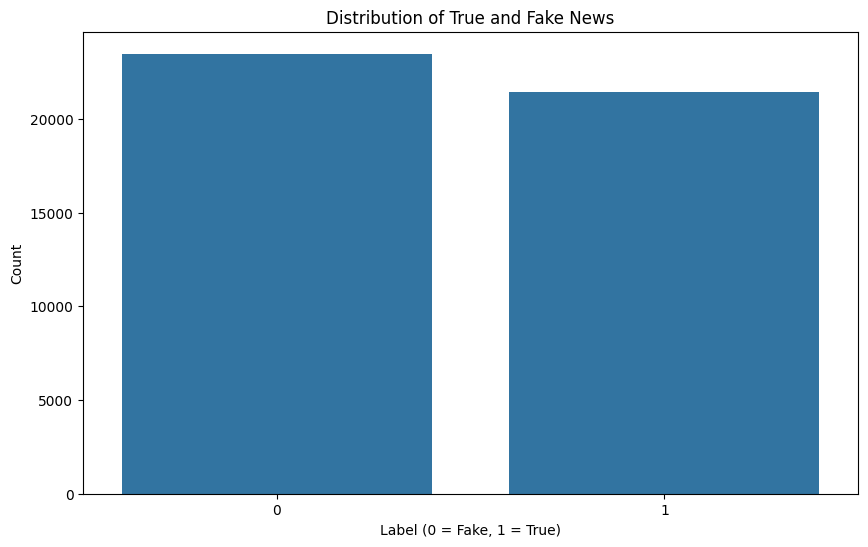

In [22]:
plt.figure(figsize=(10, 6))
sns.countplot(data=dataset, x='label')
plt.title('Distribution of True and Fake News')
plt.xlabel('Label (0 = Fake, 1 = True)')
plt.ylabel('Count')
plt.show()

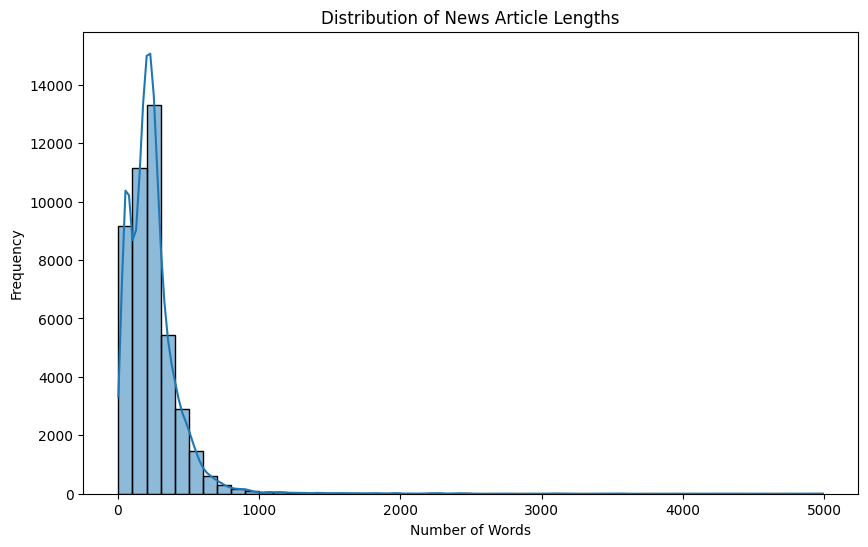

In [23]:
article_lengths = dataset['data'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(article_lengths, bins=50, kde=True)
plt.title('Distribution of News Article Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

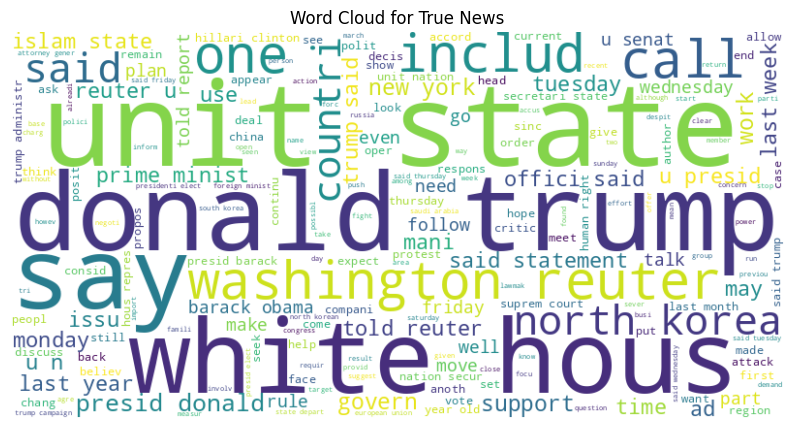

In [24]:
from wordcloud import WordCloud
true_text = ' '.join(dataset[dataset['label'] == 1]['data'])
true_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(true_text)
plt.figure(figsize=(10, 6))
plt.imshow(true_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for True News')
plt.axis('off')
plt.show()


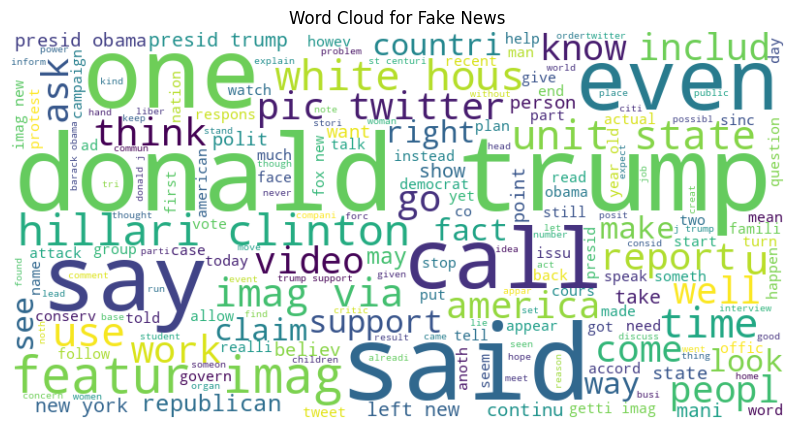

In [25]:
fake_text = ' '.join(dataset[dataset['label'] == 0]['data'])
fake_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(fake_text)
plt.figure(figsize=(10, 6))
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Fake News')
plt.axis('off')
plt.show()

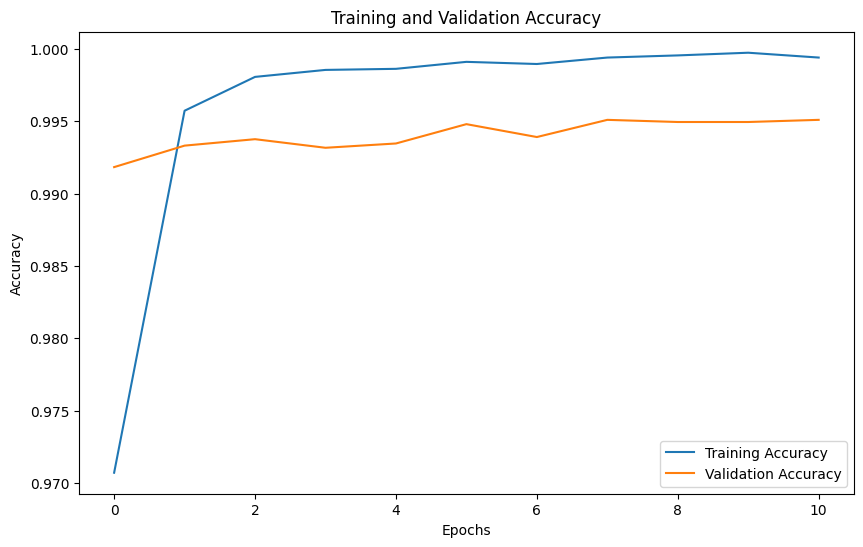

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

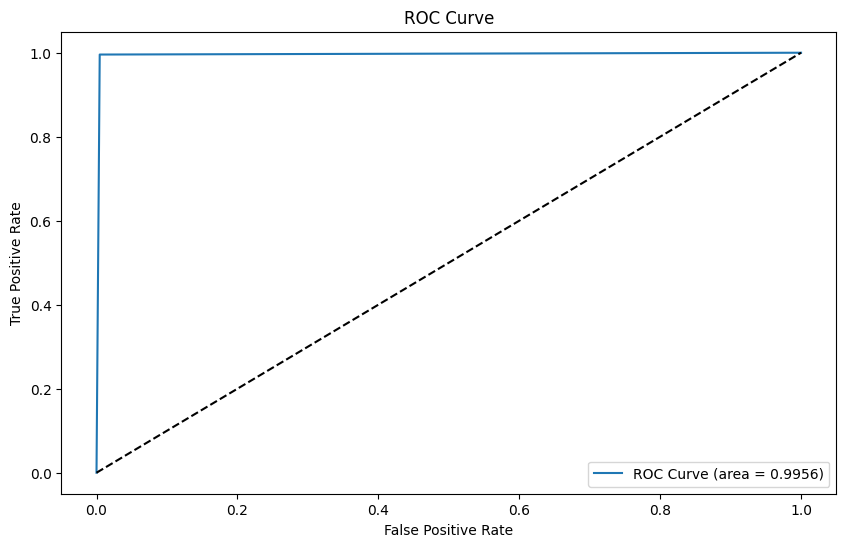

In [27]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

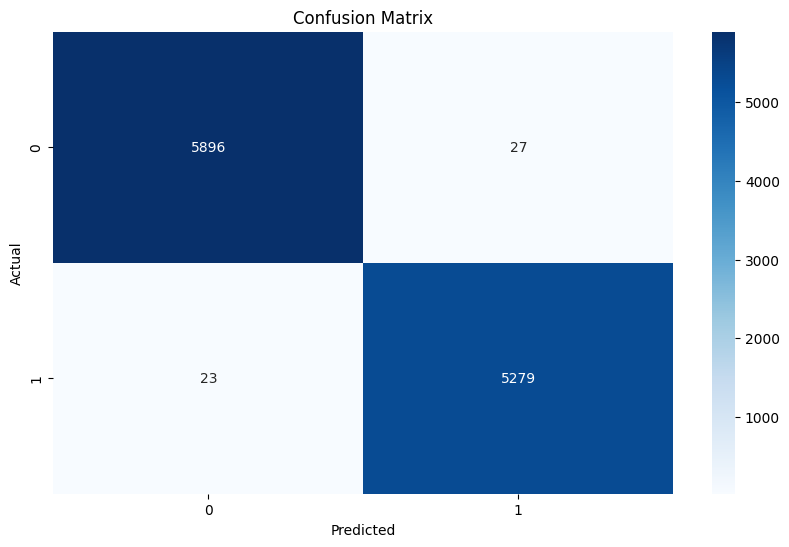

In [28]:
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [30]:

sample_fake_news = "Breaking news! The moon is made of cheese according to new research by scientists. This finding is surprising and contradicts all previous studies. Cheese manufacturers are thrilled."
sample_fake_news_processed = preprocess_text(sample_fake_news)
sample_fake_news_vectorized = vectorizer.transform([sample_fake_news_processed]).toarray()
sample_prediction_prob = ann.predict(sample_fake_news_vectorized)
sample_prediction = sample_prediction_prob > 0.5

print(f"Sample Fake News Prediction: {'Fake' if sample_prediction else 'True'}")
print(f"Prediction Probability: {sample_prediction_prob[0][0]:.4f}")

fake_prob = 1 - sample_prediction_prob[0][0]
print(f"Adjusted Sample Fake News Prediction: {'Fake' if fake_prob > 0.5 else 'True'}")
print(f"Adjusted Prediction Probability: {fake_prob:.4f}")


1/1 [==============================] - 0s 27ms/step
Sample Fake News Prediction: True
Prediction Probability: 0.0002
Adjusted Sample Fake News Prediction: Fake
Adjusted Prediction Probability: 0.9998
